In [17]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt

### Initial state initialyzing

In [18]:
n, l = 3, 4 # количество видов узлов и возможных взаимодействий между ними
alpha = np.array([100, 4, 0]) # уязвимые, заражённые, невосприимчивые, лекарство
N = sum(alpha)
Vs = N // 2 - 1 # скорость сканирования ip4 адресов вирусом [узел/сек]
lmb = 0.02 # интенсивность потока заражения [скорость * кол-во узлов / размер адресного пространства]
imm = lmb * 5 # интенсивность потока лечения заражения
a = lmb * 100 # интенсивность потока добавления новых узлов в компьютерную сеть
eps = np.array([[1, 1, 0], #заражение
                [0, 1, 0], # лечение заражённого
                [1, 0, 0], # иммунизация уязвимого
                [0, 0, 0]]) # добавление нового узла
phi = np.array([lmb*alpha[0]*alpha[1], imm*alpha[1], imm*alpha[0], a]) # интенсивности потоков, учитывая количество частиц
p_gamma = np.array([[0, 2, 0], # два заражённых
                    [0, 0, 1], # новый неуязвимый
                    [0, 0, 1], # новый неуязвимый
                    [1, 0, 0]]) # новый уязвимый

### Process

In [19]:
def inverse_exp(random_, coef):
    '''возвращает значение случайной величины,
    распределённой по экспоненциальному закону,
    соответствующему простейшему Пуассоновскому потоку'''
    if coef == 0:
        return np.finfo(np.float32).max
    return -1/coef * math.log(1 - random_)
    #return 1/coef

tau = np.array([0 for _ in range(l)], dtype=np.float32) # время следующего события i
for i in range(l):
    tau[i] = inverse_exp(random.random(), phi[i])

def update_tau(tau, ):
    ''' Возвращает матрицу с временами событий на следующем шаге и ближайшее событие
    :param tau: array of trigger times, generated on the previous step
    :return: times array on the next step, next event, time of next event'''
    min_ = np.finfo(np.float32).max
    idx_min = 0

    for k in range(len(tau)):
        if tau[k] == np.finfo(np.float32).max and phi[k] != 0:
            tau[k] = inverse_exp(random.random(), phi[k])
        if tau[k] < min_:
            min_ = tau[k]
            idx_min = k
    tau -= min_
    return tau, idx_min, min_

def update_phi(alpha):
    phi = np.array([lmb*alpha[0]*alpha[1], imm*alpha[1], imm*alpha[0], a])
    phi[~np.all(eps <= alpha, axis=1)] = 0
    return phi

def taking_action(alpha, next_event):
    """Совершаем следующее предопределённое действие
    :param alpha: array of existing particles
    :param next_event: next event with prerequisites from eps and consequences determined from p_gamma
    :return: next state and new probabilities of events"""
    alpha += -eps[next_event] + p_gamma[next_event]
    phi = update_phi(alpha)
    return alpha, phi


### Running K steps

In [ ]:
k = 400
particles_history = np.empty((k + 1, n))
times = np.empty(k + 1)
particles_history[0, :] = alpha
times[0] = 0
print(alpha)
for i in range(1, k + 1):
    tau, next_event, delta_time = update_tau(tau)
    alpha, phi = taking_action(alpha, next_event)
    tau[next_event] = inverse_exp(random.random(), phi[next_event])
    particles_history[i, :] = alpha
    times[i] = delta_time + times[i - 1]
    print(f"after {i} step:")
    print("tau:", tau, "\nphi:", phi, "\nalpha:", alpha, "\nevent:", next_event)


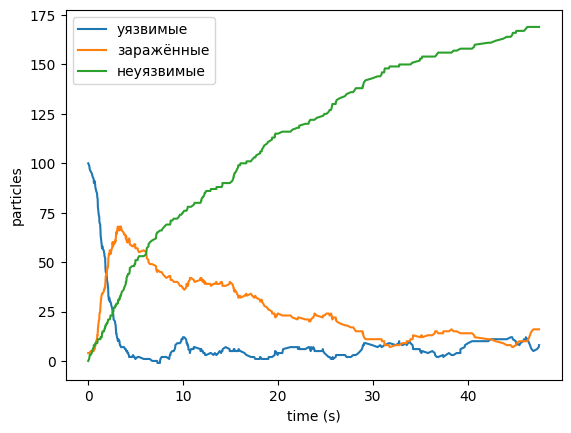

In [21]:
states = ["уязвимые", "заражённые", "неуязвимые"]
def plot_particles_history(particles_history, times):
    for i in range(n):
        plt.plot(times, particles_history[:, i], label=f"{states[i]}")
    plt.xlabel("time (s)")
    plt.ylabel("particles")
    plt.legend()
    plt.show()

plot_particles_history(particles_history, times)

### Obtaining 40 trajectories with 200 steps

In [ ]:
# Фактически в общем случае получится 40 * 200 уникальных значений времени. Значит придётся
# интерполировать функции s(t), i(t), r(t) на значения времени из других траекторий, что создаст
# суммарно 40 * 200 * 3 значений в массиве состояний
k = 400
trj = 500
particles_history = np.empty((trj, k + 1, n))
times = np.empty((trj, k + 1))
particles_history[:, 0, :] = np.array([100, 4, 0])
times[:, 0] = 0

for j in range(trj):
    alpha = np.array([100, 4, 0])
    tau = np.array([0 for _ in range(l)], dtype=np.float32) # время следующего события i
    for i in range(l):
        tau[i] = inverse_exp(random.random(), phi[i])

    phi = np.array([lmb*alpha[0]*alpha[1], imm*alpha[1], imm*alpha[0], a])

    for i in range(1, k + 1):
        tau, next_event, delta_time = update_tau(tau)
        alpha, phi = taking_action(alpha, next_event)
        tau[next_event] = inverse_exp(random.random(), phi[next_event])
        particles_history[j, i, :] = alpha
        times[j, i] = delta_time + times[j, i - 1]
        if j == 0 or j == 1 or j == 2:
            print(f"after {i} step:")
            print("tau:", tau, "\nphi:", phi, "\nalpha:", alpha, "\nevent:", next_event)

### Obtaining mean of trajectories

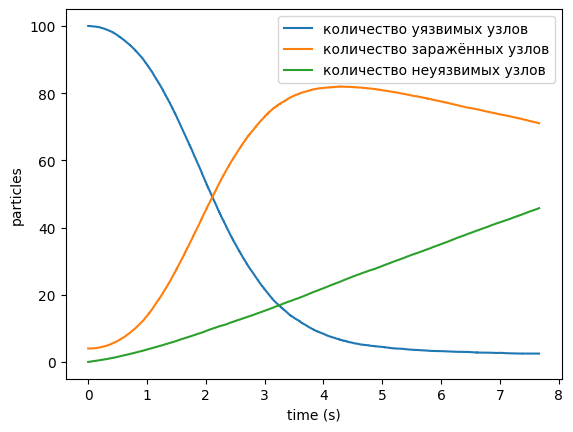

In [23]:
# Сложность алгоритма по времени O(trj^2 * (k - 2)) * O(np.mean)
# по памяти O(trj * (k - 2) * n); n - количество разных видов частиц (узлов)
indices = np.ones(trj, dtype=int)
cum_indices = np.zeros(trj, dtype=int)
merged = [np.array([100, 4, 0])]
total_times = [0]

for i in range(trj * (k - 2)):
    idx_min = np.argmin(times[np.arange(trj), indices])
    cum_indices[idx_min] = min(cum_indices[idx_min] + 1, 200)
    indices[idx_min] = min(indices[idx_min] + 1, 200)

    merged.append(np.mean(particles_history[np.arange(trj), cum_indices, :], axis=0))
    total_times.append(times[idx_min, cum_indices[idx_min]])

plt.plot(total_times, merged, label=["количество уязвимых узлов", "количество заражённых узлов", "количество неуязвимых узлов"])
plt.xlabel("time (s)")
plt.ylabel("particles")
plt.legend()
plt.show()

In [ ]:
print(particles_history[[1, 2, 3], :4, :])